In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv("../data/static_annotations_averaged_songs_1_2000.csv")
df2 = pd.read_csv("../data/static_annotations_averaged_songs_2000_2058.csv")

df = pd.concat([df1, df2], ignore_index=True)

print(df.shape)
df.head()

(1802, 13)


,song_id,valence_mean,valence_std,arousal_mean,arousal_std,valence_ max_mean,valence_max_std,valence_min_mean,valence_min_std,arousal_max_mean,arousal_max_std,arousal_min_mean,arousal_min_std
0,2,3.1,0.94,3.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,3.5,1.75,3.3,1.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,5.7,1.42,5.5,1.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,4.4,2.01,5.3,1.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,5.8,1.47,6.4,1.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.columns


Index(['song_id', ' valence_mean', ' valence_std', ' arousal_mean',
       ' arousal_std', ' valence_ max_mean', ' valence_max_std',
       ' valence_min_mean', ' valence_min_std', ' arousal_max_mean',
       ' arousal_max_std', ' arousal_min_mean', ' arousal_min_std'],
      dtype='object')

In [4]:
#clean the extra space 
df.columns = df.columns.str.strip()
df.columns


Index(['song_id', 'valence_mean', 'valence_std', 'arousal_mean', 'arousal_std',
       'valence_ max_mean', 'valence_max_std', 'valence_min_mean',
       'valence_min_std', 'arousal_max_mean', 'arousal_max_std',
       'arousal_min_mean', 'arousal_min_std'],
      dtype='object')

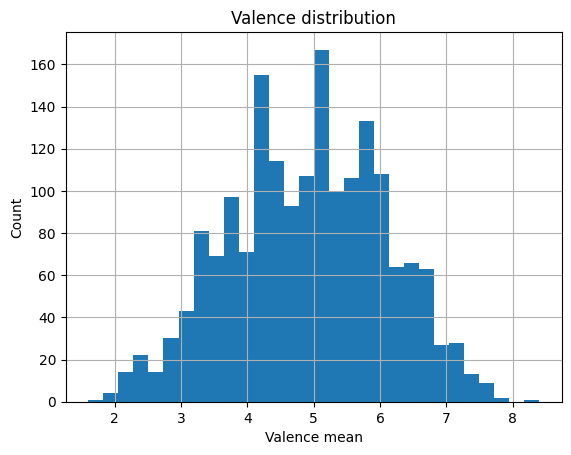

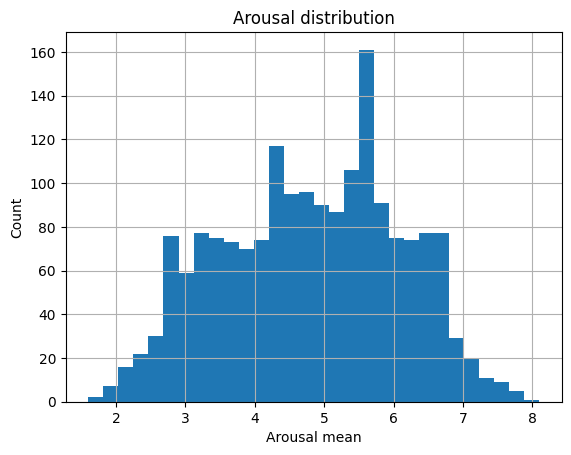

In [5]:
val_col = "valence_mean"
aro_col = "arousal_mean"

plt.figure()
df[val_col].hist(bins=30)
plt.title("Valence distribution")
plt.xlabel("Valence mean")
plt.ylabel("Count")
plt.show()

plt.figure()
df[aro_col].hist(bins=30)
plt.title("Arousal distribution")
plt.xlabel("Arousal mean")
plt.ylabel("Count")
plt.show()


In [6]:
df[[val_col, aro_col]].describe()


,valence_mean,arousal_mean
count,1802.000000,1802.000000
mean,4.904145,4.814029
std,1.174240,1.282187
min,1.600000,1.600000
25%,4.100000,3.800000
50%,4.900000,4.900000
75%,5.800000,5.800000
max,8.400000,8.100000
